# RFM Analysis using Customer Segmentation
Clustering using kmeans++

Step 1 : Import Libraries

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

Step 2: Import Data

In [32]:
def import_data(customers, products, orders, sales):
    # Read relevant files
    customers_record = pd.read_csv(customers)
    products_record = pd.read_csv(products)
    orders_record = pd.read_csv(orders)
    sales_record = pd.read_csv(sales)

    # Merge all records into one dataframe
    merged_record = pd.merge(customers_record, orders_record, on="customer_id")
    merged_record = pd.merge(merged_record, sales_record, on="order_id")
    merged_record = pd.merge(merged_record, products_record, on="product_id")
    return merged_record

In [33]:
rfm_data = import_data("customers.csv", "products.csv", "orders.csv", "sales.csv")
print(rfm_data.head())

   customer_id  customer_name  gender  age                    home_address  \
0            1  Leanna Busson  Female   30  8606 Victoria TerraceSuite 560   
1            1  Leanna Busson  Female   30  8606 Victoria TerraceSuite 560   
2            1  Leanna Busson  Female   30  8606 Victoria TerraceSuite 560   
3            1  Leanna Busson  Female   30  8606 Victoria TerraceSuite 560   
4            1  Leanna Busson  Female   30  8606 Victoria TerraceSuite 560   

   zip_code           city               state    country  order_id  ...  \
0      5464  Johnstonhaven  Northern Territory  Australia       455  ...   
1      5464  Johnstonhaven  Northern Territory  Australia       455  ...   
2      5464  Johnstonhaven  Northern Territory  Australia       670  ...   
3      5464  Johnstonhaven  Northern Territory  Australia       670  ...   
4      5464  Johnstonhaven  Northern Territory  Australia       670  ...   

   price_per_unit quantity_x total_price  product_type   product_name  siz

Step 3: Prepare Data
For recency, find the latest date from the dataset, ideally this is current date

In [34]:
def prepare_data(data):
    #convert order_date column into datetime object
    data['order_date'] = pd.to_datetime(data['order_date'])
    
    latest_date = data['order_date'].max()

    #Find the recency (number of days since purchase) of each customer by subtracting the last day they purchased from the latest date
    recency_data = data.groupby('customer_id')['order_date'].max().reset_index()
    recency_data['recency'] = (latest_date - recency_data['order_date']).dt.days

    #Find the frequency (how often the customer has prurchased) of each customer
    frequency_data = data.groupby('customer_id').size().reset_index(name='frequency')

    #Find the total money each customer has spent on the website
    monetary_data = data.groupby('customer_id')['total_price'].sum().reset_index()

    #Merge all data
    processed_data = pd.merge(recency_data, frequency_data, on="customer_id")
    processed_data = pd.merge(processed_data, monetary_data, on="customer_id")

    return processed_data

In [35]:
rfm_data_processed = prepare_data(rfm_data)
print(rfm_data_processed.head())

   customer_id order_date  recency  frequency  total_price
0            1 2021-04-04      203          8         1641
1            7 2021-05-21      156          5         1017
2           10 2021-03-09      229          1          270
3           11 2021-05-28      149          2          382
4           12 2021-06-19      127          8         1551


Step 4: Normalise Data
(Tried both MinMaxScalar and StandardScalar)

In [36]:
def normalise_data(data):
    #Normalise key attributes to avoid overrepresentation in clustering method
    scaler = StandardScaler()
    scaled_rfm = scaler.fit_transform(data[['recency', 'frequency', 'total_price']])
    return scaled_rfm

In [37]:
rfm_normalised = normalise_data(rfm_data_processed)
print(rfm_normalised)

[[ 0.95577015 -0.0228773  -0.03180973]
 [ 0.39795659 -0.61006128 -0.61561177]
 [ 1.26434787 -1.39297326 -1.31449018]
 ...
 [-0.84822265  0.95576267  1.28174487]
 [-0.30227746  2.52158663  2.56348974]
 [-1.29922085 -0.41433329 -0.1796314 ]]


Step 4. Apply K means++ with optimal K value (Elbow method)

In [38]:
def apply_optimal_kmeans_plus(data, min_k=1, max_k=10):
    k_range = range(min_k, max_k + 1)

    sse = []

    #Find Sum of Squared Errors for each k in min-max range
    for k in k_range:
        kmeans_plus = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmeans_plus.fit(data)
        sse.append(kmeans_plus.inertia_)

    #create elbow plot
    plt.xlabel('K')
    plt.ylabel('Sum of Squared Error')
    plt.plot(k_range, sse)
    plt.show()

    #Find optimal k using elbow method
    optimal_k = sse.index(min(sse)) + min_k

    #Implement k-means++ clustering method using optimal k
    kmeans_plus = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
    kmeans_plus.fit(data)
    return kmeans_plus

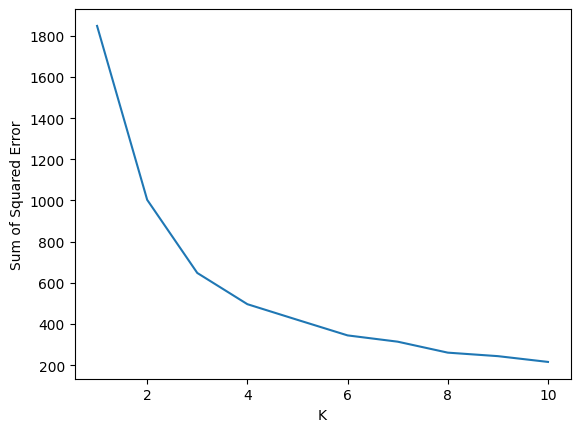

In [39]:
optimal_kmeans_plus = apply_optimal_kmeans_plus(rfm_normalised)

Step 5:  Optimal K value is 2. 
To illustrate, however, let's use K means++ with K value = 4 for additional clusters.

In [40]:
def apply_kmeans_plus(data, k=4):
    #Implement k-means++ clustering method using chosen k
    kmeans_plus = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans_plus.fit(data)
    return kmeans_plus

In [41]:
kmeans_plus = apply_kmeans_plus(rfm_normalised)
rfm_data_processed['cluster'] = kmeans_plus.labels_
print(rfm_data_processed)

     customer_id order_date  recency  frequency  total_price  cluster
0              1 2021-04-04      203          8         1641        2
1              7 2021-05-21      156          5         1017        2
2             10 2021-03-09      229          1          270        2
3             11 2021-05-28      149          2          382        2
4             12 2021-06-19      127          8         1551        3
..           ...        ...      ...        ...          ...      ...
611          994 2021-01-12      285          7         1716        2
612          995 2021-08-02       83         10         2140        3
613          996 2021-09-03       51         13         3045        3
614          998 2021-07-19       97         21         4415        0
615         1000 2021-10-11       13          6         1483        1

[616 rows x 6 columns]


Step 6. Visualise clusters

In [42]:
def visualise_clusters(data, kmeans_plus):
    # create plot
    fig = plt.figure(figsize=(10, 8))
    sub_fig = fig.add_subplot(111, projection='3d')
    
    # plot each cluster
    for cluster_id in range(kmeans_plus.n_clusters):
        cluster_data = data[data['cluster'] == cluster_id]
        sub_fig.scatter(cluster_data['recency'], cluster_data['frequency'], cluster_data['total_price'], label=f"Cluster {cluster_id}")

    # label graph
    sub_fig.set_title("Customer Cluster (Recency, Frequency, Monetary)")
    sub_fig.set_xlabel("Recency (days)")
    sub_fig.set_ylabel("Frequency")
    sub_fig.set_zlabel("Monetary Value ($)")
    sub_fig.legend()

    plt.show()


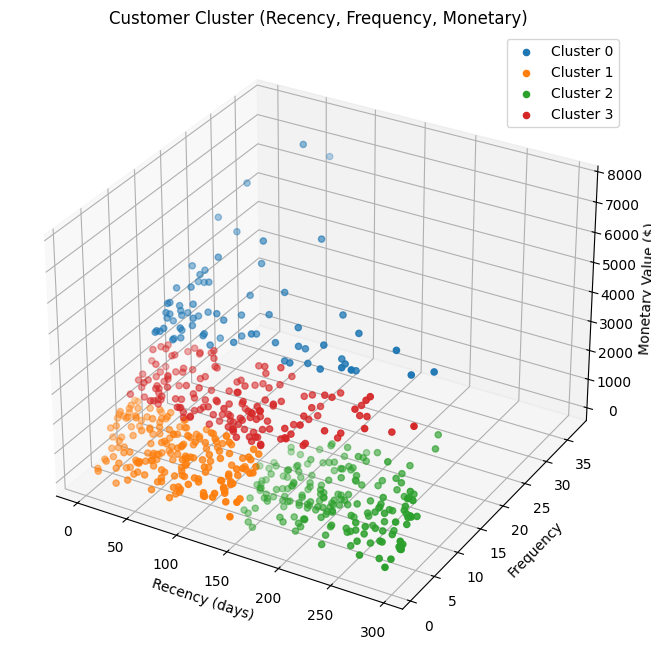

In [43]:
visualise_clusters(rfm_data_processed, kmeans_plus)

Step 7. Derive insights from clusters

Note: This method has been designed to print output after analysing the cluster patterns
    We may consider adjusting the rules for labelling the active/inactive customer, high/low purchase frequency
    or high/low monetary value segment

In [44]:
def derive_insights(data, kmeans_plus):
    for cluster_id in range(kmeans_plus.n_clusters):
        print(f"Cluster {cluster_id}:")
        cluster_data = data[data['cluster'] == cluster_id]

        # acquire cluster recency stats
        recency_min = cluster_data['recency'].min()
        recency_max = cluster_data['recency'].max()
        recency_avg = cluster_data['recency'].mean()

        # acquire cluster frequenct stats
        frequency_min = cluster_data['frequency'].min()
        frequency_max = cluster_data['frequency'].max()
        frequency_avg = cluster_data['frequency'].mean()

        # acquire cluster total price stats
        total_price_min = cluster_data['total_price'].min()
        total_price_max = cluster_data['total_price'].max()
        total_price_avg = cluster_data['total_price'].mean()

        customer_count = cluster_data.shape[0]

        # print formatted and annotated cluster stats
        print(f"Number of customers: {customer_count}")
        print(f"Recency (Min, Max, Avg): {recency_min}, {recency_max}, {recency_avg:.2f} days")
        print(f"Frequency (Min, Max, Avg): {frequency_min}, {frequency_max}, {frequency_avg:.2f}")
        print(f"Total price (Min, Max, Avg): ${total_price_min}, ${total_price_max}, ${total_price_avg:.2f}")
        
        # characterise cluster recency
        if recency_avg > 100:
            print("Recency Segment: Inactive Customers")
        elif recency_avg < 100:
            print("Recency Segment: Active Customers")

        # characterise cluster frequency
        if frequency_avg > 5:
            print("Frequency Segment: High Frequency")
        elif frequency_avg < 5:
            print("Frequency Segment: Low Frequency")

        # characterise cluster total price
        if total_price_avg > 3000:
            print("Monetary Segment: High Monetary Value")
        elif total_price_avg < 3000:
            print("Monetary Segment: Low Monetary Value")

        print("\n")


In [45]:
print(derive_insights(rfm_data_processed, kmeans_plus))

Cluster 0:
Number of customers: 74
Recency (Min, Max, Avg): 0, 253, 66.72 days
Frequency (Min, Max, Avg): 13, 37, 18.30
Total price (Min, Max, Avg): $2785, $7632, $3819.64
Recency Segment: Active Customers
Frequency Segment: High Frequency
Monetary Segment: High Monetary Value


Cluster 1:
Number of customers: 190
Recency (Min, Max, Avg): 0, 143, 67.58 days
Frequency (Min, Max, Avg): 1, 9, 4.82
Total price (Min, Max, Avg): $112, $1765, $999.41
Recency Segment: Active Customers
Frequency Segment: Low Frequency
Monetary Segment: Low Monetary Value


Cluster 2:
Number of customers: 191
Recency (Min, Max, Avg): 145, 296, 222.20 days
Frequency (Min, Max, Avg): 1, 13, 5.23
Total price (Min, Max, Avg): $100, $2674, $1066.36
Recency Segment: Inactive Customers
Frequency Segment: High Frequency
Monetary Segment: Low Monetary Value


Cluster 3:
Number of customers: 161
Recency (Min, Max, Avg): 1, 261, 94.56 days
Frequency (Min, Max, Avg): 7, 15, 10.76
Total price (Min, Max, Avg): $1498, $3264, $